# Sistema de Recomendación

En este notebook vamos a crear un sistema de recomendación. Para ello seguiremos los siguientes pasos:
* Crear un dataframe donde los indices sean los id de los juegos y haya 401 columnas con one-hot encoding representando "genres", "tags" y "specs". Esta tabla está bastante avanzada en el archivo "steam_games_procesado.csv".
* Haremos **TF-IDF** para vectorizar los títulos de los juegos y los concatenaremos con el dataframe anterior.
* Como el dataframe resultante tendrá mas de 20000 columnas, haremos reducción de dimensionalidad usando **PCA**.
* Utilizaremos esta tabla para crear una donde tanto filas como columnas sean id de juegos y los campos sean las distancias de coseno entre ellos.
* A partir de lo mismo armaremos un archivo json, donde las llaves serán los id de los juegos y los valores, una lista con los 5 id de juego mas similares.
* También crearemos un csv que contenga nombre e id de cada juego.
* Estos 2 archivos, json y csv, serán consumidos por la API para dar respuesta a su consulta sobre los 5 juegos mas similares al de referencia, y por tanto recomendados.

In [6]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from langdetect import detect
from sklearn.decomposition import PCA
from wordcloud import WordCloud

In [2]:
# Cargar el archivo "steam_games_procesado.csv"
df = pd.read_csv("./Datasets/steam_games_procesado.csv")

# Eliminar las columnas "genres", "tags", "specs" y "year".
df.drop(columns=["genres", "tags", "specs", "year"], inplace=True)

df.head(2)

,id,app_name,genres_Accounting,genres_Action,genres_Adventure,genres_Animation & Modeling,genres_Audio Production,genres_Casual,genres_Design & Illustration,genres_Early Access,...,specs_Steam Achievements,specs_Steam Cloud,specs_Steam Leaderboards,specs_Steam Trading Cards,specs_Steam Turn Notifications,specs_Steam Workshop,specs_SteamVR Collectibles,specs_Tracked Motion Controllers,specs_Valve Anti-Cheat enabled,specs_Windows Mixed Reality
0,761140,Lost Summoner Kitty,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,643980,Ironbound,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


Hagamos un análisis de las palabras más repetidas en los títulos con una nube de palabras.

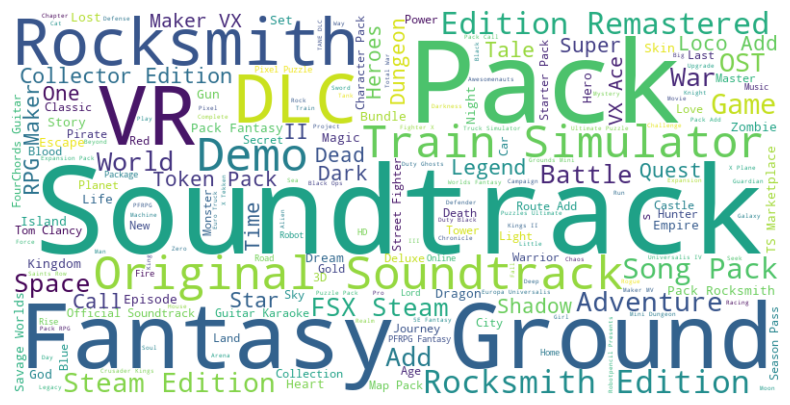

In [34]:
# Concatenar todos los títulos de juegos en una sola cadena
text = ' '.join(df['app_name'].astype(str))

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

Vemos algunas que se destacan mucho como Soundtrack, Pack, Fantasy y Ground, entre otras. También es notable que la mayoría de las palabras mas frecuentes corresponden al inglés. Analicemos que idiomas están presentes.

In [35]:
# Definir una función para detectar el idioma de un texto.
def detect_language(text):
    try:
        return detect(text)
    except:
        return None  # Manejo de errores en caso de que no se pueda detectar el idioma

# Aplica la función de detección de idioma a la columna 'app_name'
df['language'] = df['app_name'].apply(detect_language)

In [36]:
print(f"El número de lenguajes que aparecen en los nombres es {df.language.nunique()}.")

El número de lenguajes que aparecen en los nombres es 39.


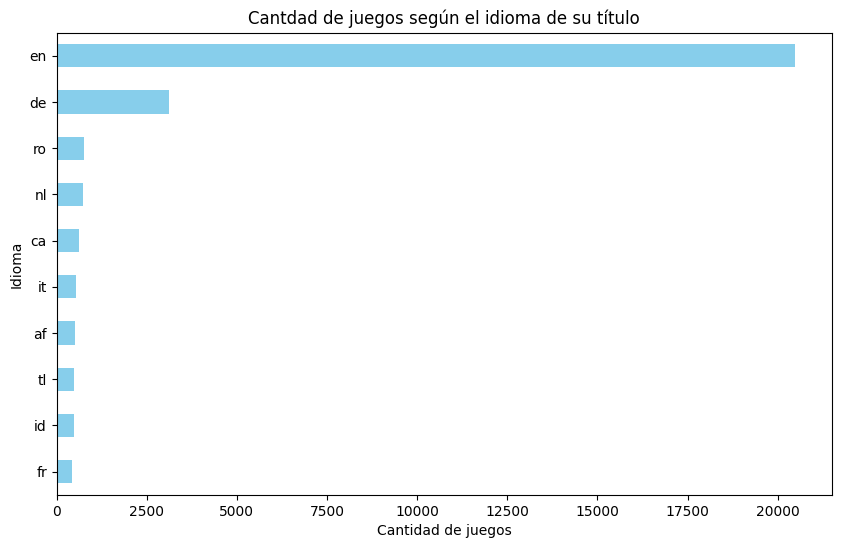

In [37]:
# Analizar los 10 lenguajes más frecuentes.
top_languages = df['language'].value_counts().head(10)

# Crear un gráfico de barras horizontales.
plt.figure(figsize=(10, 6))
top_languages.plot(kind='barh', color='skyblue')
plt.xlabel('Cantidad de juegos')
plt.ylabel('Idioma')
plt.title('Cantdad de juegos según el idioma de su título')
plt.gca().invert_yaxis();  # Invertir el eje y para que el idioma más común esté en la parte superior.


Al igual que notabamos con la nube de palabras, el inglés es el idioma mas frecuente por gran diferencia. Ya no utilizaremos la columna "language", porque estará implicita en el proceso de TF-IDF, por lo que la eliminaremos.

In [38]:
df.drop(columns=["language"], inplace=True)

Ahora que ya hemos descripto un poco los títulos, pasaremos a vectorizarlos usando TF-IDF. Al haber 39 idiomas, no se llevará a cabo el proceso de lematizacion, radicalización (stemming) ni eliminación de stopwords antes de aplicar TF-IDF, a pesar de que esto implique un aumento en la dimensionalidad. No obstante, la eliminación de stopwords en TF-IDF generalmente no es crítica debido a su método de cálculo. Las stopwords suelen tener valores de TF-IDF bajos, ya que son palabras comunes que aparecen en muchos documentos, lo que diluye su importancia relativa.

In [3]:
# Crear una instancia de TfidfVectorizer.
tfidf_vectorizer = TfidfVectorizer()

# Ajustar el vectorizador y transformar los títulos en representaciones TF-IDF.
tfidf_matrix = tfidf_vectorizer.fit_transform(df['app_name'])

# Convertir la matriz TF-IDF a un DataFrame.
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),
                        columns=tfidf_vectorizer.get_feature_names_out())

# Concatenar el DataFrame original 'df' con el DataFrame de TF-IDF 'tfidf_df'.
df = pd.concat([df, tfidf_df], axis=1)

In [4]:
df.head(2)

,id,app_name,genres_Accounting,genres_Action,genres_Adventure,genres_Animation & Modeling,genres_Audio Production,genres_Casual,genres_Design & Illustration,genres_Early Access,...,魔神少女エピソード２,鸿源战纪,麻将vr,黄昏下的月台上,黒の宮殿,龙魂时刻,유죄,평결,한국어,４人打ちアクション麻雀
0,761140,Lost Summoner Kitty,0,1,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,643980,Ironbound,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Haremos un dataframe para guardar la relación id/app_name y lo guardaremos en un .csv

In [5]:
# Crear el dataframe solo con las columnas id y app_name.
id_name_df = df[["id", "app_name"]]

# Guardar el dataframe con csv.
id_name_df.to_csv("./Datasets_API/id_name.csv", index=False)

Ahora en el dataframe original eliminaremos "app_name" y setearemos el indice en "id".

In [6]:
df.drop(columns=["app_name"], inplace=True)
df.set_index("id", inplace=True)
df.head(2)

,genres_Accounting,genres_Action,genres_Adventure,genres_Animation & Modeling,genres_Audio Production,genres_Casual,genres_Design & Illustration,genres_Early Access,genres_Education,genres_Free to Play,...,魔神少女エピソード２,鸿源战纪,麻将vr,黄昏下的月台上,黒の宮殿,龙魂时刻,유죄,평결,한국어,４人打ちアクション麻雀
id,,,,,,,,,,,,,,,,,,,,,
761140,0,1,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
643980,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Un dataframe con 20037 columnas tiene una dimensionalidad muy alta para calcular las distancias de coseno. Por ello, antes haremos una reducción de dimensionalidad usando Análisis de componentes principales.

In [7]:
n_components = 100  # Número de componentes principales a retener.

# Crear una instancia de PCA.
pca = PCA(n_components=n_components)

# Ajustar y transformar el dataframe con la instancia creada.
df_reduced = pca.fit_transform(df)

Vamos a calcular las similitudes de coseno entre los juegos y crear un dataframe que las contenga.

In [8]:
# Calcular las distancias de coseno el array reducido.
cosine_distances = cosine_similarity(df_reduced)

# Crear un nuevo DataFrame con las distancias de coseno.
cosine_df = pd.DataFrame(cosine_distances, index=df.index, columns=df.index)

Vamos a visualizar los primeros resultados del DataFrame cosine_df.

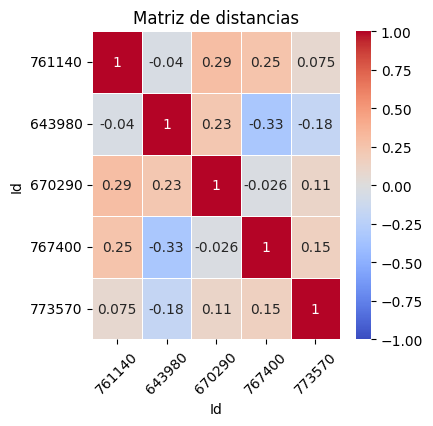

In [9]:
import seaborn as sns
plt.figure(figsize=(4, 4))
heatmap = sns.heatmap(cosine_df.iloc[:5,:5], annot=True, cmap='coolwarm',
                      linewidths=0.5, vmin=-1, vmax=1)

# Añadir etiquetas a los ejes
plt.xlabel('Id')
plt.ylabel('Id')
plt.title("Matriz de distancias")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()

Ahora crearemos un diccionario, donde la llave sea el id del juego y el valor, una lista con los 5 juegos con menor distancia de coseno (exculyendo al propio juego).

In [10]:
# Crear un diccionario para almacenar los resultados.
result_dict = {}

# Iterar a través de las filas del DataFrame
for index, row in cosine_df.iterrows():
    # Encontrar del 2º al 6º valor más alto en la fila actual.
    top_values = row.nlargest(6).index[1:6].tolist()

    # Almacenar el resultado en el diccionario con el índice de la fila como clave.
    result_dict[index] = top_values

Veamos los primeros elementos del diccionario para visualizar su estructura.

In [11]:
from itertools import islice

dict(islice(result_dict.items(), 3))

{761140: [718360, 705430, 705400, 707370, 706320],
 643980: [219340, 377150, 461910, 291410, 344190],
 670290: [522660, 645260, 729580, 590290, 427040]}

Ahora guardaremos este diccionario como un archivo json para ser consultado por la API.

In [12]:
with open('./Datasets_API/top_5_recomendados.json', 'w') as archivo_json:
    json.dump(result_dict, archivo_json)

Vamos a probar la función que trabaja igual que la de la API.

In [4]:
def recomendacion_juego(id_ref: int):
    # Crear un dataframe a partir "top_5_recomendados.json".
    # Las columnas son los id del juego de referencia y las 5 filas los id
    # de los juegos mas similares.
    df = pd.read_json("./Datasets_API/top_5_recomendados.json")

    # Crear un dataframe a partir "id_name.csv".
    id_name_df = pd.read_csv("./Datasets_API/id_name.csv")

    res = {} # Crear un diccionario vacio para ser retornado como json.

    # df[id_ref] es una serie de Pandas correspondiente a la columna "id_ref"
    # del dataframe df. "val" contiene los id de los juegos
    for idx, val in df[id_ref].items():
        # Se obtiene el nombre del juego.
        name = id_name_df[id_name_df.id == val].app_name.item()
        # Se guarda en el diccionario el id como llave y el nombre como valor.
        res[val] = name

    return res

Cargaremos de nuevo "steam_games_procesado.csv" para probar esta función.

In [9]:
games_df = pd.read_csv("./Datasets/steam_games_procesado.csv")
games_df = games_df.iloc[:, :5]
games_df.head(3)

,id,app_name,genres,tags,specs
0,761140,Lost Summoner Kitty,"['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']","['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']",['Single-player']
1,643980,Ironbound,"['Free to Play', 'Indie', 'RPG', 'Strategy']","['Free to Play', 'Strategy', 'Indie', 'RPG', 'Card Game', 'Trading Card Game', 'Turn-Based', 'Fantasy', 'Tactical', 'Dark Fantasy', 'Board Game', 'PvP', '2D', 'Competitive', 'Replay Value', 'Character Customization', 'Female Protagonist', 'Difficult', 'Design & Illustration']","['Single-player', 'Multi-player', 'Online Multi-Player', 'Cross-Platform Multiplayer', 'Steam Achievements', 'Steam Trading Cards', 'In-App Purchases']"
2,670290,Real Pool 3D - Poolians,"['Casual', 'Free to Play', 'Indie', 'Simulation', 'Sports']","['Free to Play', 'Simulation', 'Sports', 'Casual', 'Indie', 'Multiplayer']","['Single-player', 'Multi-player', 'Online Multi-Player', 'In-App Purchases', 'Stats']"


Probemos la función con el id 729620, correspondiente a el juego de Pool "Malzbie's Pinball Collection - The Garden Table".

In [18]:
id_ref = 729620

In [19]:
# Obtener las llaves (id) de los juegos recomendados
ids_recomendados = recomendacion_juego(id_ref).keys()

ids_recomendados

dict_keys([729600, 342590, 729580, 342600, 330280])

In [23]:
# Ajustar las opciones de visualización.
pd.set_option('display.max_colwidth', None)

# Visualizar los juegos recomendados.
#games_df[(games_df.id == id_ref) | (games_df.id.isin(ids_recomendados))]
df_ref = games_df[(games_df.id == id_ref)]
df_rec = games_df[(games_df.id.isin(ids_recomendados))]
pd.concat([df_ref, df_rec], axis=0)

,id,app_name,genres,tags,specs
12095,729620,Malzbie's Pinball Collection - The Garden Table,"['Casual', 'Indie', 'Simulation', 'Sports']","['Indie', 'Casual', 'Simulation', 'Sports']","['Single-player', 'Downloadable Content', 'Steam Achievements', 'Full controller support']"
4853,342600,Pure Hold'em - Vortex Chip Set,"['Casual', 'Indie', 'Simulation', 'Sports', 'Strategy']","['Strategy', 'Indie', 'Casual', 'Simulation', 'Sports']","['Single-player', 'Multi-player', 'Downloadable Content', 'Steam Achievements', 'Full controller support']"
12096,729600,Malzbie's Pinball Collection - Carnival Table,"['Casual', 'Indie', 'Simulation', 'Sports']","['Indie', 'Casual', 'Simulation', 'Sports']","['Single-player', 'Downloadable Content', 'Steam Achievements', 'Full controller support']"
14556,729580,Malzbie's Pinball Collection,"['Casual', 'Free to Play', 'Indie', 'Simulation', 'Sports']","['Free to Play', 'Indie', 'Casual', 'Simulation', 'Sports']","['Single-player', 'Steam Achievements', 'Full controller support']"
23560,342590,Pure Hold'em - Paradise City Chipset,"['Casual', 'Indie', 'Simulation', 'Sports']","['Indie', 'Casual', 'Simulation', 'Sports']","['Single-player', 'Multi-player', 'Downloadable Content', 'Steam Achievements', 'Full controller support']"
25231,330280,Pure Hold'em - King's Ransom Chip Set,"['Casual', 'Indie', 'Simulation', 'Sports', 'Strategy']","['Strategy', 'Indie', 'Casual', 'Simulation', 'Sports']","['Single-player', 'Multi-player', 'Downloadable Content', 'Steam Achievements', 'Full controller support']"


Podemos ver similitudes en cuanto a nombre, género, etiquetas y especificaciones.